In [1]:
# Imports 
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.summary.summary_iterator import summary_iterator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from collections import defaultdict

import re

## Reward Function Stuff

In [20]:
# Toy Imports
import gym
from gym import spaces

In [217]:
class WordleToy(gym.Env): 
    
    def __init__(self, 
                 n_boards: int = 1,
                 n_letters: int = 5,
                 n_guesses: int = 6,
                 answers: list = None,
                 subset_valid_words: int = 0,
                 subset_answers: int = 0,
                 seed: int = None,
                 keep_answers_on_reset: bool = False,
                 valid_words: list = None,
                 reward_type: str  = 'elim'):
        
        """
        n_boards: number of boards that are played at once
        n_letters: number of letters per word
        n_guesses: number of guesses per board
        answers: list of answers. If None then answers are selected at random
        seed: seed for selecting random answers. If None then different answers will be selected each time
        keep_answers_on_reset: whether we should select new answers on each reset.
        """
        
        
        # Store attributes 
        self.n_boards = n_boards
        self.n_letters = n_letters
        self.n_guesses = n_guesses
        self.seed = seed 
        np.random.seed(self.seed)
        self.keep_answers_on_reset = keep_answers_on_reset
        self.reward_type = reward_type
        
        # Create the list of valid words of length n_letters
        self.valid_words = valid_words if valid_words is not None else [word.lower() for word in english_words_set if len(word) == self.n_letters]
        self.valid_words = [word for word in self.valid_words if "'" not in word and "." not in word and "&" not in word]
        self.valid_words = sorted(self.valid_words)


        if subset_valid_words:
            self.valid_words = np.random.choice(self.valid_words, subset_valid_words).tolist()
        if subset_answers:
            self.valid_answers = np.random.choice(self.valid_words, subset_answers).tolist()
        else:
            self.valid_answers = self.valid_words

        
        # Create answers. If we pass a list it will set as answers. Otherwise it will generate a list 
        # of size n_boards of random answers. 
        # Alternatively, we can pass a seed for reproducibility
        if answers is not None: 
            assert(isinstance(answers, list))
            assert(len(answers) == self.n_boards)
            assert([len(answer) == self.n_letters for answer in answers])
            self.answers = answers
        else: 
            self.answers = np.random.choice(self.valid_answers, self.n_boards).tolist()

        # create encoder and decoder for later use in self._encode and self._decode
        self.encoder = dict(zip(list("abcdefghijklmnopqrstuvwxyz"), np.arange(26)))
        self.decoder = dict(zip(np.arange(26), list("abcdefghijklmnopqrstuvwxyz")))

        self.encoded_answers = [self._encode(answer) for answer in self.answers]
            
            
        # Action Space 
        self.action_space = spaces.Discrete(len(self.valid_words))
        
        # Observation Space 
        self.obs_dims = self.n_boards * self.n_letters * self.n_guesses * 2 # 2 for letters/colors
        self.observation_space = spaces.Box(low = -1,
                                            high = 25, 
                                            shape = (self.obs_dims,), 
                                            dtype = int)
        # Initialize State
        self.state = -1 * np.ones(self.obs_dims, dtype = int)
        
        # Initialize tracking variables
        self.guess_count = 0
        self.wins = [False] * self.n_boards # tracks which boards have been won already
        self.done = False # overall is the game done
        self.board_guess_counts = [self.guess_count] * self.n_boards # guess count for each board
        self.green_letters = [] # letters that we know are green
        self.yellow_letters = [] # letters that are yellow (runs into case of guessing the same letter in two spots and it's yellow both times)
        # but we'll ignore for now

        self.possible_words = self.valid_words
        self.alphabet = ['a', 'b', 'c' , 'd', 'e', 'f', 'g', 'h', 'i', 
            'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
            't', 'u', 'v', 'w', 'x', 'y', 'z']
        
    def _encode(self, word: str): 
        """
        Inputs a word of length n_letters as a string and maps to a list of ints corresponding to 
        each letter a = 0, b = 1, ..., z = 25
        """
        return [self.encoder[letter] for letter in word]    
    
    def _decode(self, letters_list: list):
        return [self.decoder[idx] for idx in letters_list]               
        
    def _convert_state_to_grids(self, state_1d): 
        
        """
        Converts the 1d array into a list of dictionaries. Note that the 2
        comes from the fact that we have separate grids for letters and colors.
        [ {'letters': [...], 'colors': [...]}, {'letters': [...], 'colors': [...]}, ..., ]
        """
        
        # Convert the 1d array into an array of size n_boards x 2 * n_guesses x n_letters
        state = state_1d.reshape(( self.n_boards, 2 * self.n_guesses, self.n_letters, ))
        
        # Convert into list of dictionaries 
        state_list = [{'letters': board[:self.n_guesses], 'colors': board[self.n_guesses:]} for board in state]
        
        return state_list
    
    def _convert_grids_to_state(self, boards): 
        
        """
        Converts the states from list of dictionaries to a single flattened list of size 
        n_boards * n_guesses * n_letters * 2 (2 because we have separate grids for letters and colors)
        
        boards: list of dict of form [ {'letters': [...], 'colors': [...]}, {'letters': [...], 'colors': [...]}, ..., ]
        """
        
        return np.array([np.append(board['letters'], board['colors']) for board in boards], dtype=int).flatten()

    def compute_single_board_sparse_reward(self, board: dict, board_guess_count: int):


        """
        Because green is 2, the max score is 2 x number of letters
        We give a score of -1 for any bad guessses

        board: dict of form {'letters': [...], 'colors': [...]}
        """


        score = np.sum(board['colors'][board_guess_count])
        max_score = 2 * self.n_letters
        reward = 1 if score == max_score else -1

        # return reward
        return reward
    
    def compute_single_board_info_gain_reward(self, board: dict, board_guess_count: int, decoded_answer, decoded_guess):
    
        """
        Because green is 2, the max score is 2 x number of letters
        We give a score of -1 for any bad guessses
    
        board: dict of form {'letters': [...], 'colors': [...]}
        """
        
        new_greens, new_yellows, other_letters = 0, 0, 0
        for guess_letter, answer_letter in zip(decoded_guess, decoded_answer): 
            
            if (guess_letter == answer_letter) and (guess_letter not in self.green_letters): 
                new_greens += 1
                self.green_letters.append(guess_letter)
            elif (guess_letter in decoded_answer) and (guess_letter not in self.yellow_letters): 
                new_yellows += 1
                self.yellow_letters.append(guess_letter)
            else: 
                other_letters += 1
                            
                
        score = 2 * new_greens + 1 * new_yellows - other_letters
          
    
        # Check if won board
        won = (decoded_guess == decoded_answer)
        if not won:
            score -= 10

        return score
    
    def compute_single_board_word_elim_reward(self, board: dict, board_guess_count: int, decoded_answer: str, 
                                    decoded_guess: str): 
        
        """
        Computes the number of words eliminated
        """
        
        # Green dictionary with keys = 0, 1, ..., n_letter and value = '' if no green or letter if green
        green_letters = dict(zip(range(self.n_letters), ['']*self.n_letters))
        
        # Yellow dict with keys = 0, 1, ..., n_letters and values are lsits of yellows
        yellow_letters = defaultdict(list)
        
        # list of gray letters
        gray_letters = []
        for idx, (guess_letter, answer_letter) in enumerate(zip(decoded_guess, decoded_answer)): 

            # Green Letter
            if guess_letter == answer_letter: 
                green_letters.update({idx: guess_letter})

            # yellow letter
            elif guess_letter in decoded_answer: 
                yellow_letters[idx].append(guess_letter)

            # Gray letter
            else: 
                gray_letters.append(guess_letter)
                
                
        # Remove gray letters from the alphabet
        self.alphabet = sorted(set(self.alphabet) - set(gray_letters))
        
        # Create the new pattern
        pattern = r''
        for i in range(self.n_letters): 

            # Check if there is green or yellow
            is_green = green_letters[i] != ''
            has_yellow = len(yellow_letters[i])  > 0

            if is_green: 
                # if green then it should just be that letter as the only option
                letter_pattern = '[' + green_letters[i] + ']'

            elif has_yellow: 
                
                # if yellow then it's the alphabet minus the letters that can't be there
                letter_alphabet = [letter for letter in self.alphabet if letter not in yellow_letters[i]]
                letter_pattern = '[' + ''.join(letter_alphabet) + ']'

            else: 
                # otherwise just the remaining alphabet
                letter_pattern = '[' + ''.join(self.alphabet) + ']'

            pattern += letter_pattern
            
        # Filter possible words 
        new_possible_words = [word for word in self.possible_words if bool(re.match(pattern, word))]


        # Compute reward 
        reward = (len(self.possible_words) - len(new_possible_words))/len(self.possible_words) - 1
        # print(f'Reduced words from {len(self.possible_words)} to {len(new_possible_words)}')
        self.possible_words = new_possible_words
            
        # Check if the board won
        if decoded_guess == decoded_answer or (len(new_possible_words) == 1 and board_guess_count < 6):
            reward = 1
            
        return reward
   
    def update_single_board(self, 
                            board: dict, 
                            action: int, 
                            encoded_answer: list,
                            board_guess_count: int,
                            board_win: bool): 
        
        """
        Takes the action as index from list of actions and converts to words/list of letter-numbers
        and then updates the board
        {'green': 2, 
         'yellow': 1, 
         'gray': 0, 
         'empty': -1}
         
         board: dict of form {'letters': [...], 'colors': [...]}
         action: integer for the index of self.valid_words selected as the guess
         encoded_answer: the board answer encoded into list of integers
         board_win: boolean for whether the board has already been won or not. If so, it doesn't update anythign 
         (i.e. doesn't make the guess)
         
        """
        
        # If the game is over, we can't make any guesses
        if self.done: 
            return board, 0, True, board_guess_count
        
        # If the board is complete, we can't make any guesses
        elif board_win: 
            
            return board, 0, True, board_guess_count
        
        else: 
                    
            # Grab action
            decoded_action = self.valid_words[action]
            encoded_action = self._encode(decoded_action)

            # Update letters grid 
            board['letters'][board_guess_count] = encoded_action

            # Insert new color records
            board['colors'][board_guess_count] = self._new_colors(encoded_answer, encoded_action)


            # Compute board reward 
            decoded_answer = self._decode(encoded_answer)
            
            if self.reward_type == 'sparse': 
                board_reward = self.compute_single_board_sparse_reward(board, board_guess_count)
            elif self.reward_type == 'gain': 
                board_reward = self.compute_single_board_info_gain_reward(board, board_guess_count, 
                                                                          decoded_answer, decoded_action)
            elif self.reward_type == 'elimination': 
                board_reward = self.compute_single_board_word_elim_reward(board, board_guess_count, 
                                                                          decoded_answer, decoded_action)            
            

            board_win = len(self.possible_words) == 1 or decoded_answer == decoded_action

            # Increment guess count on that board
            board_guess_count += 1
            
            return board, board_reward, board_win, board_guess_count

    def _new_colors(self, encoded_answer, encoded_action):
        # Update colors
        new_colors = []
        for answer_letters, guess_letter in zip(encoded_answer, encoded_action):

            # Green letter (i.e. correct letter in correct spot)
            if guess_letter == answer_letters:
                new_colors.append(2)
                if guess_letter not in self.green_letters:
                    self.green_letters.append(guess_letter)

            # Yellow letter (i.e. correct letter in incorrect spot)
            elif guess_letter in encoded_answer:
                new_colors.append(1)
                if guess_letter not in self.green_letters:
                    self.yellow_letters.append(guess_letter)

            # Gray letter (i.e. incorrect letter)
            else:
                new_colors.append(0)

        return new_colors
    
    def step(self, action: int): 
        
        """
        Updates each board using the same action and then checks rewards/increments state/etc
        
        action: integer for the index of self.valid_words selected as the guess
        """
        
        # Convert the 1d state into grids for easier use 
        state_list = self._convert_state_to_grids(self.state)
        
        # Initialize stats for updating all boards to track everything
        # these will update the global attributes later
        step_boards = []
        step_rewards = []
        step_wins = []
        step_board_guess_counts = []
        for idx, board in enumerate(state_list): 

            # Get board answer and whether we've finished this board
            encoded_answer = self.encoded_answers[idx]
            board_win = self.wins[idx]
            board_guess_count = self.board_guess_counts[idx]


            # Update each board 
            new_board, board_reward, win, board_guess_count = self.update_single_board(board, 
                                                                                       action, 
                                                                                       encoded_answer, 
                                                                                       board_guess_count,
                                                                                       board_win)


            # Append step information 
            step_boards.append(new_board)
            step_rewards.append(board_reward)
            step_wins.append(win)
            step_board_guess_counts.append(board_guess_count)


        # Compute total reward as mean of reward across n_boards. Picked mean so it's same reward across envs
        reward = np.mean(step_rewards)

        # Increment guess count 
        self.guess_count += 1


        # Check stopping conditions
        win = np.all(step_wins)
        reached_max_guesses = self.guess_count == self.n_guesses
        self.done = bool((reached_max_guesses) or (win))

        # Update info
        self.wins = step_wins
        self.board_guess_counts = step_board_guess_counts
        self.info = {'guess_count': self.guess_count, 
                     'boards_win': self.wins, 
                     'board_guess_counts': self.board_guess_counts, 
                     'win': win} 

        # Convert grids back to 1d state
        self.state = self._convert_grids_to_state(step_boards)

        return self.state, reward, self.done, self.info
    
    def reset(self, seed = None, return_info = False):
        
        """
        Resets the environment
        
        seed: random seed for selecting random answers. If none, the random answers won't be reproducible
        return_info: boolean for whether we should return the info from the last game
        """
    
        # Create answers. We can keep answers as well.
        if self.keep_answers_on_reset:
            self.answers = self.answers
            self.encoded_answers = [self._encode(answer) for answer in self.answers]
        else: 
            self.answers = np.random.choice(self.valid_answers, self.n_boards).tolist()
            self.encoded_answers = [self._encode(answer) for answer in self.answers]
                        
        # Initialize State
        self.state = -1 * np.ones(self.obs_dims, dtype = int)
        
        # Initialize tracking variables
        self.guess_count = 0
        self.wins = [False] * self.n_boards # tracks which boards have been won already
        self.done = False # overall is the game done
        self.board_guess_counts = [self.guess_count] * self.n_boards # guess count for each board
        
        self.green_letters = [] # letters that we know are green
        self.yellow_letters = [] # letters that are yellow (runs into case of guessing the same letter in two spots and it's yellow both times)
        # but we'll ignore for now
        
        self.possible_words = self.valid_words
        self.alphabet = ['a', 'b', 'c' , 'd', 'e', 'f', 'g', 'h', 'i', 
            'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
            't', 'u', 'v', 'w', 'x', 'y', 'z']
    
        if return_info:
            return self.state, self.info
                        
        return self.state

In [218]:
# Get wordle words
wordle_words = open("scripts/wordle_words.txt", "r").read().split(",")
wordle_words = [word.replace('\n', '') for word in wordle_words]

env = WordleToy(n_boards = 1, 
                n_letters = 5, 
                n_guesses = 6, 
                answers = ['adore'],  
                subset_valid_words = None, 
                subset_answers = None, 
                valid_words = wordle_words, 
                reward_type = 'sparse', 
                keep_answers_on_reset = True)

In [219]:
# SPARSE REWARD
# Sparse Reward - Strategy 1
_ = env.reset()
guesses = ['audio', 'adopt', 'adorn', 'adore']
sparse_1 = []
for guess in guesses: 
    _, reward, _, _ = env.step(env.valid_words.index(guess))
    sparse_1.append(reward)
    
# Sparse Reward - Strategy 2
_ = env.reset()
guesses = ['flame', 'brick', 'podgy', 'shunt', 'adore']
sparse_2 = []
for guess in guesses: 
    _, reward, _, _ = env.step(env.valid_words.index(guess))
    sparse_2.append(reward)
    
# Sparse Reward - Random
_ = env.reset()
sparse_3 = []
for i in range(6): 
    _, reward, _, _ = env.step(env.action_space.sample())
    sparse_3.append(reward)

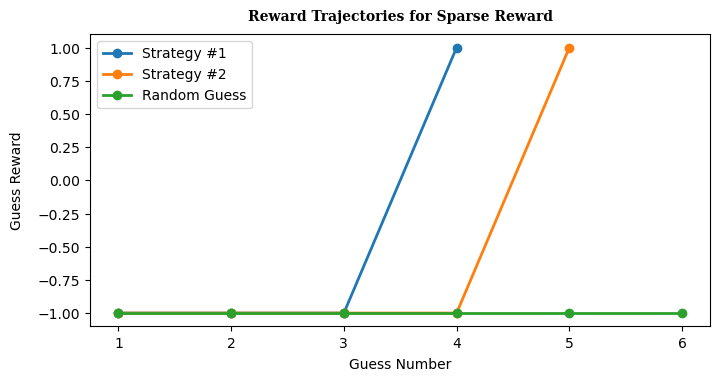

In [238]:
# Plot
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.15)

plt.plot(sparse_1, lw = 2, marker = 'o', label = 'Strategy #1')
plt.plot(sparse_2, lw = 2, marker = 'o', label = 'Strategy #2')
plt.plot(sparse_3, lw = 2, marker = 'o', label = 'Random Guess')

plt.xticks(range(6), range(1, 7))

plt.xlabel('Guess Number', labelpad = 5)
plt.ylabel('Guess Reward', labelpad = 10)
plt.title('Reward Trajectories for Sparse Reward', font = 'serif', fontweight = 'bold', pad = 10)
plt.legend();
# fig.savefig('report_plots/sparse_reward_trajectories.png')

In [221]:
# New Env
wordle_words = open("scripts/wordle_words.txt", "r").read().split(",")
wordle_words = [word.replace('\n', '') for word in wordle_words]

env = WordleToy(n_boards = 1, 
                n_letters = 5, 
                n_guesses = 6, 
                answers = ['adore'],  
                subset_valid_words = None, 
                subset_answers = None, 
                valid_words = wordle_words, 
                reward_type = 'gain', 
                keep_answers_on_reset = True)

In [241]:
# INFO GAIN REWARD

# Strategy 1
_ = env.reset()
guesses = ['audio', 'adopt', 'adorn', 'adore']
gain_1 = []
for guess in guesses: 
    _, reward, _, _ = env.step(env.valid_words.index(guess))
    gain_1.append(reward)
    
# Strategy 2
_ = env.reset()
guesses = ['flame', 'brick', 'podgy', 'shunt', 'adore']
gain_2 = []
for guess in guesses: 
    _, reward, _, _ = env.step(env.valid_words.index(guess))
    gain_2.append(reward)
    
# Random
_ = env.reset()
gain_3 = []
for i in range(6): 
    _, reward, _, _ = env.step(env.action_space.sample())
    gain_3.append(reward)

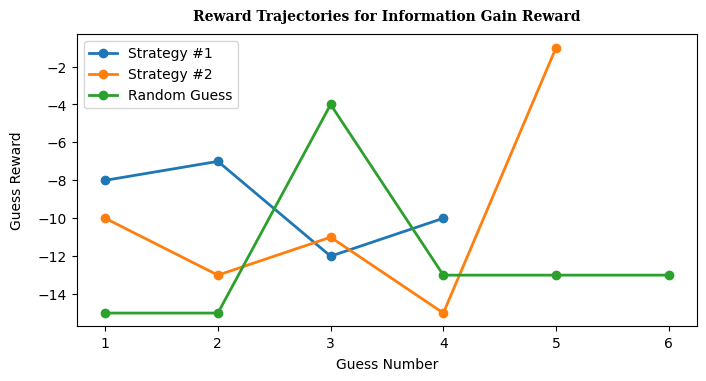

In [240]:
# Plot
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.15)

plt.plot(gain_1, lw = 2, marker = 'o', label = 'Strategy #1')
plt.plot(gain_2, lw = 2, marker = 'o', label = 'Strategy #2')
plt.plot(gain_3, lw = 2, marker = 'o', label = 'Random Guess')

plt.xticks(range(6), range(1, 7))

plt.xlabel('Guess Number', labelpad = 5)
plt.ylabel('Guess Reward', labelpad = 10)
plt.title('Reward Trajectories for Information Gain Reward', font = 'serif', fontweight = 'bold', pad = 10)
plt.legend();
fig.savefig('report_plots/info_gain_reward_trajectories.png')

In [229]:
# New Env
wordle_words = open("scripts/wordle_words.txt", "r").read().split(",")
wordle_words = [word.replace('\n', '') for word in wordle_words]

env = WordleToy(n_boards = 1, 
                n_letters = 5, 
                n_guesses = 6, 
                answers = ['adore'],  
                subset_valid_words = None, 
                subset_answers = None, 
                valid_words = wordle_words, 
                reward_type = 'elimination', 
                keep_answers_on_reset = True)

In [254]:
# Word elimination REWARD

# Strategy 1
_ = env.reset()
guesses = ['audio', 'adopt', 'adorn', 'adore']
elim_1 = []
elim_1_pw = [len(env.possible_words)]
for guess in guesses: 
    _, reward, _, _ = env.step(env.valid_words.index(guess))
    elim_1.append(reward)
    elim_1_pw.append(len(env.possible_words))

    
# Strategy 2
_ = env.reset()
guesses = ['flame', 'brick', 'podgy', 'shunt', 'adore']
elim_2 = []
elim_2_pw = [len(env.possible_words)]
for guess in guesses: 
    _, reward, _, _ = env.step(env.valid_words.index(guess))
    elim_2.append(reward)
    elim_2_pw.append(len(env.possible_words))

    
# Random
_ = env.reset()
elim_3 = []
elim_3_pw = [len(env.possible_words)]
for i in range(6): 
    _, reward, _, _ = env.step(env.action_space.sample())
    elim_3.append(reward)
    elim_3_pw.append(len(env.possible_words))


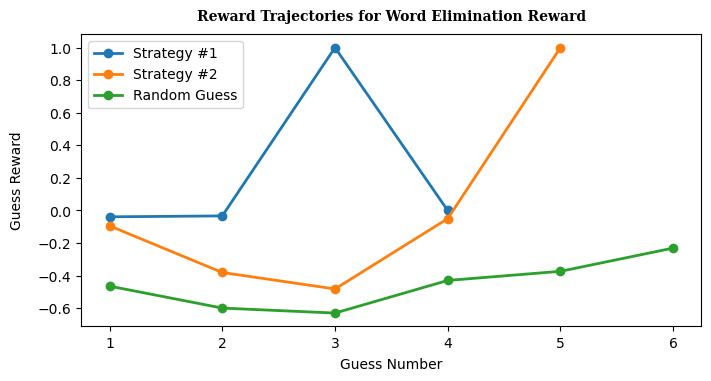

In [255]:
# Plot
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.15)

plt.plot(elim_1, lw = 2, marker = 'o', label = 'Strategy #1')
plt.plot(elim_2, lw = 2, marker = 'o', label = 'Strategy #2')
plt.plot(elim_3, lw = 2, marker = 'o', label = 'Random Guess')

plt.xticks(range(6), range(1, 7))

plt.xlabel('Guess Number', labelpad = 5)
plt.ylabel('Guess Reward', labelpad = 10)
plt.title('Reward Trajectories for Word Elimination Reward', font = 'serif', fontweight = 'bold', pad = 10)
plt.legend();
fig.savefig('report_plots/word_elim_reward_trajectories.png')

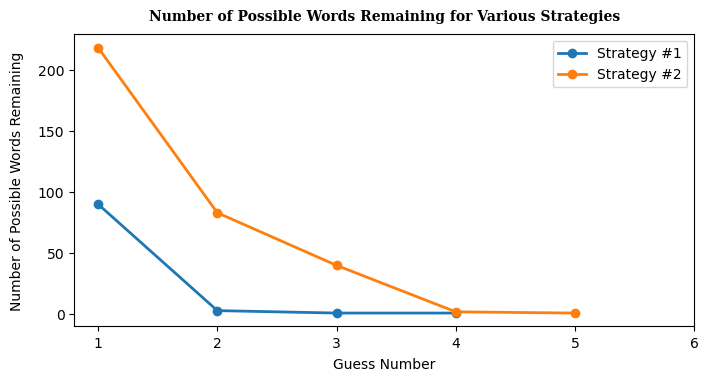

In [257]:
# Plot
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.15)

plt.plot(elim_1_pw[1:], lw = 2, marker = 'o', label = 'Strategy #1')
plt.plot(elim_2_pw[1:], lw = 2, marker = 'o', label = 'Strategy #2')
# plt.plot(elim_3_pw[1:], lw = 2, marker = 'o', label = 'Random Guess')

plt.xticks(range(6), range(1, 7))

plt.xlabel('Guess Number', labelpad = 5)
plt.ylabel('Number of Possible Words Remaining', labelpad = 10)
plt.title('Number of Possible Words Remaining for Various Strategies', font = 'serif', fontweight = 'bold', pad = 10)
plt.legend();
fig.savefig('report_plots/word_elim_possible_words.png')

## Baseline

In [34]:
# Grab Data 
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_win_1_guess_minus_1_07-12-2022_20-30-38/PPO_1'
path += '/' + os.listdir(path)[0]
ep_len_list, ep_rew_list = [],[]

value_loss, policy_loss, entropy_loss = [],[],[]
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'rollout/ep_len_mean': 
            ep_len_list.append(v.simple_value)
        elif v.tag == 'rollout/ep_rew_mean': 
            ep_rew_list.append(v.simple_value)
        elif v.tag == 'train/value_loss': 
            value_loss.append(v.simple_value)
        elif v.tag == 'train/policy_loss': 
            policy_loss.append(v.simple_value)
        elif v.tag == 'train/entropy_loss': 
            entropy_loss.append(v.simple_value)

Text(0.5, 1.0, 'Baseline PPO Average Episode Length (Elimination Reward)')

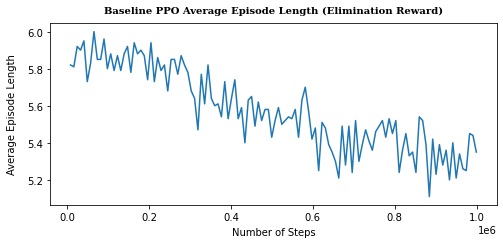

In [69]:
# Episode Length 
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.25)
plt.plot(2048*4*np.arange(1, len(ep_len_list)+1), ep_len_list)
plt.xlabel('Number of Steps', labelpad = 5)
plt.ylabel('Average Episode Length', labelpad = 10)
plt.title('Baseline PPO Average Episode Length (Elimination Reward)', font = 'serif', fontweight = 'bold', pad = 10)
# fig.savefig('report_plots/ppo_baseline_ep_len.png')

Text(0.5, 1.0, 'Baseline PPO Average Episode Reward (Elimination Reward)')

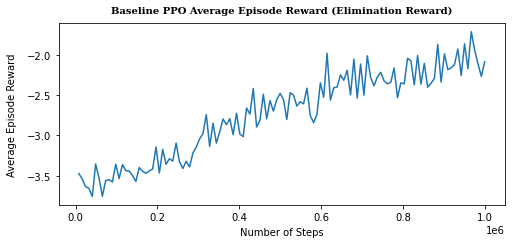

In [70]:
# Episode Length 
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.25)
plt.plot(2048*4*np.arange(1, len(ep_rew_list)+1), ep_rew_list)
plt.xlabel('Number of Steps', labelpad = 5)
plt.ylabel('Average Episode Reward', labelpad = 10)
plt.title('Baseline PPO Average Episode Reward (Elimination Reward)', font = 'serif', fontweight = 'bold', pad = 10)
# fig.savefig('report_plots/ppo_baseline_reward.png')

Text(0.5, 1.0, 'Baseline PPO Entropy Loss (Elimination Reward)')

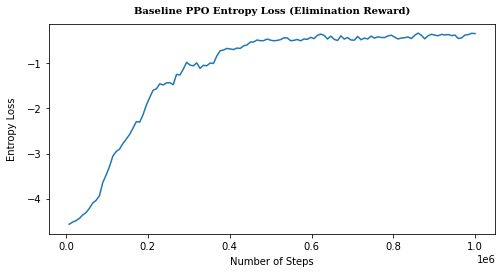

In [72]:
# Losses
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.15)

plt.plot(2048*4*np.arange(1, len(entropy_loss)+1), entropy_loss)

plt.xlabel('Number of Steps', labelpad = 5)
plt.ylabel('Entropy Loss', labelpad = 10)
plt.title('Baseline PPO Entropy Loss (Elimination Reward)', font = 'serif', fontweight = 'bold', pad = 10)
# fig.savefig('report_plots/ppo_baseline_entropy_loss.png')

#### Win Logs

In [16]:
# win_10_lose_minus_10
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_win_10_lose_minus_10_07-12-2022_19-05-41/win_logs'
path += '/' + os.listdir(path)[0]
win_10_lose_minus_10_win_rate_list = []
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'win_ratio': 
            win_10_lose_minus_10_win_rate_list.append(v.simple_value)

In [21]:
# win_10_guess_minus_10
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_win_10_guess_minus_10_07-12-2022_19-28-27/win_logs'
path += '/' + os.listdir(path)[0]
win_10_guess_minus_10_win_rate_list = []
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'win_ratio': 
            win_10_guess_minus_10_win_rate_list.append(v.simple_value)

In [24]:
# win_1_guess_minus_1
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_win_1_guess_minus_1_07-12-2022_20-30-38/win_logs'
path += '/' + os.listdir(path)[0]
win_1_guess_minus_1_win_rate_list = []
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'win_ratio': 
            win_1_guess_minus_1_win_rate_list.append(v.simple_value)

In [26]:
# win_1_lose_minus_1
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_win_1_lose_minus_1_07-12-2022_19-56-21/win_logs'
path += '/' + os.listdir(path)[0]
win_1_lose_minus_1_win_rate_list = []
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'win_ratio': 
            win_1_lose_minus_1_win_rate_list.append(v.simple_value)

In [28]:
# baseline elimination reward
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_elimination_baseline_07-12-2022_19-44-33/win_logs'
path += '/' + os.listdir(path)[0]
baseline_win_rate_list = []
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'win_ratio': 
            baseline_win_rate_list.append(v.simple_value)

In [61]:
np.arange(1, len(win_10_lose_minus_10_win_rate_list) + 1)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

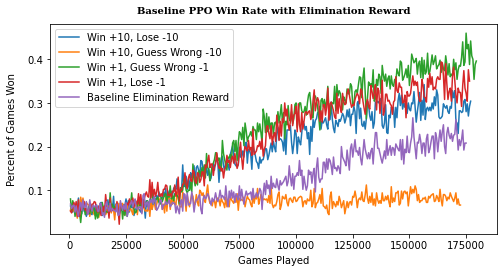

In [63]:
# Losses
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.15)

plt.plot(500 * np.arange(1, len(win_10_lose_minus_10_win_rate_list) + 1), win_10_lose_minus_10_win_rate_list, label="Win +10, Lose -10")
plt.plot(500 * np.arange(1, len(win_10_guess_minus_10_win_rate_list) + 1), win_10_guess_minus_10_win_rate_list, label= "Win +10, Guess Wrong -10")
plt.plot(500 * np.arange(1, len(win_1_guess_minus_1_win_rate_list) + 1), win_1_guess_minus_1_win_rate_list, label= "Win +1, Guess Wrong -1")
plt.plot(500 * np.arange(1, len(win_1_lose_minus_1_win_rate_list) + 1), win_1_lose_minus_1_win_rate_list, label= "Win +1, Lose -1")
plt.plot(500 * np.arange(1, len(baseline_win_rate_list) + 1), baseline_win_rate_list, label= "Baseline Elimination Reward")
plt.legend()
plt.xlabel('Games Played', labelpad = 5)
plt.ylabel('Percent of Games Won', labelpad = 10)
plt.title('Baseline PPO Win Rate with Elimination Reward', font = 'serif', fontweight = 'bold', pad = 10);
# fig.savefig('report_plots/ppo_baseline_elimination_win_rate.png')

In [47]:
# info gain reward
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_info_gain_minus_1_08-12-2022_10-49-38/win_logs'
path += '/' + os.listdir(path)[0]
info_gain_win_rate_list = []
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'win_ratio': 
            info_gain_win_rate_list.append(v.simple_value)

In [46]:
# sparse reward
path = '/Users/seantsung/Documents/GitHub/cs285_final_project/data/ppo_small_sparse_07-12-2022_17-34-12/win_logs'
path += '/' + os.listdir(path)[0]
sparse_win_rate_list = []
for e in summary_iterator(path): 
    for v in e.summary.value: 
        if v.tag == 'win_ratio': 
            sparse_win_rate_list.append(v.simple_value)

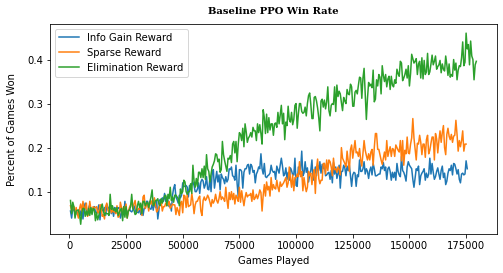

In [66]:
# Losses
fig, ax = plt.subplots(figsize = (8,4))
plt.subplots_adjust(bottom=0.15)

plt.plot(500 * np.arange(1, len(info_gain_win_rate_list) + 1), info_gain_win_rate_list, label="Info Gain Reward")
plt.plot(500 * np.arange(1, len(sparse_win_rate_list) + 1), sparse_win_rate_list, label="Sparse Reward")
plt.plot(500 * np.arange(1, len(win_1_guess_minus_1_win_rate_list) + 1), win_1_guess_minus_1_win_rate_list, label="Elimination Reward")

plt.legend()
plt.xlabel('Games Played', labelpad = 5)
plt.ylabel('Percent of Games Won', labelpad = 10)
plt.title('Baseline PPO Win Rate', font = 'serif', fontweight = 'bold', pad = 10);
# fig.savefig('report_plots/ppo_baseline_elimination_win_rate.png')